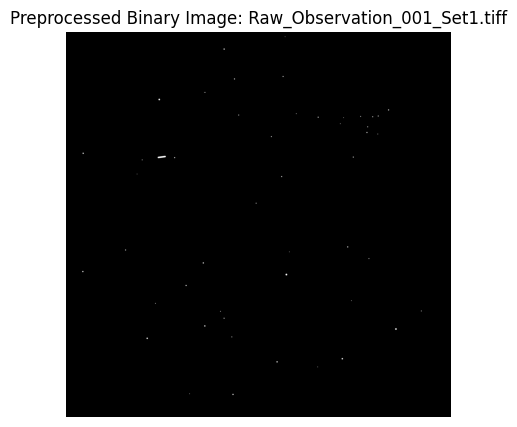

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set your image directory path
image_dir = Path(r"Datasets\Raw_Images")  # <-- change this to your actual folder path
image_paths = list(image_dir.glob("*.tiff"))
output_dir = Path(r"Processed")  # <-- change this to your actual folder path
# Output dictionary for processed binary images
preprocessed_images = {}
images_8bit = {}
pre_thres={}
# CLAHE setup
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for path in image_paths:
    # Load 16-bit grayscale image
    img_16 = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)

    if img_16 is None:
        print(f"Failed to load {path.name}")
        continue

    # Step 1: Normalize to 8-bit
    img_norm = cv2.normalize(img_16, None, 0, 255, cv2.NORM_MINMAX)
    img_8bit =  img_norm.astype(np.uint8)
    images_8bit[path.name] = img_8bit
    # Step 2: Gaussian Blur
    bilateral_filtered = cv2.bilateralFilter(img_8bit, 9, 75, 75)  # Adjust parameters as needed

    # Step 3: CLAHE
    clahe_img = clahe.apply(bilateral_filtered)
    pre_thres[path.name] = clahe_img
    hist = cv2.calcHist([clahe_img], [0], None, [256], [0, 256])
    hist = hist / hist.sum()  # Normalize to sum to 1 (optional)

# Step 3: Calculate the Cumulative Histogram
    cumulative_hist = np.cumsum(hist)

    # Step 4: Find the bin corresponding to the median
    median_bin = np.searchsorted(cumulative_hist, 0.5)

    
    # Step 4: Binary Thresholding
    _, binary = cv2.threshold(clahe_img, median_bin*2, 255, cv2.THRESH_BINARY)

    # Save binary output
    preprocessed_images[path.name] = binary
    output_path = output_dir / f"{path.stem}_binary.tiff"  # Save with _binary suffix
    cv2.imwrite(str(output_path), binary)


# Display one result for verification
sample_key = list(preprocessed_images.keys())[0]
plt.figure(figsize=(12, 5))
plt.imshow(preprocessed_images[sample_key], cmap='gray')
plt.title(f"Preprocessed Binary Image: {sample_key}")
plt.axis('off')
plt.show()


In [6]:
import cv2
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from pathlib import Path
import os

# Parameters
area_threshold = 75  # minimum area to consider
eccentricity_threshold = 0.9  # classify based on this
min_dist = 10  # pixels to consider two centroids "too close"

# Setup paths
binary_dir = preprocessed_images  # dictionary: {filename: binary_image}
originals = images_8bit           # dictionary: {filename: 8bit_original}
stars_dir = Path("stars-images")
streaks_dir = Path("streaks-images")
stars_dir.mkdir(exist_ok=True)
streaks_dir.mkdir(exist_ok=True)

# Output data
all_eccentricity_data = []
all_image_stats = []

for image_name, binary in binary_dir.items():
    original = preprocessed_images[image_name]

    # Label connected components
    labels = label(binary)
    regions = regionprops(labels)

    star_objects = []
    streak_objects = []
    filtered_regions = []

    for region in regions:
        if region.area < area_threshold:
            continue

        centroid = region.centroid
        if any(np.linalg.norm(np.array(centroid) - np.array(r.centroid)) < min_dist for r in filtered_regions):
            continue  # Filter duplicates

        filtered_regions.append(region)
        eccentricity = region.eccentricity
        bbox = region.bbox
        x, y = int(centroid[0]), int(centroid[1])

        # Crop the region from original image
        crop = original[bbox[0]:bbox[2], bbox[1]:bbox[3]]

        if eccentricity < eccentricity_threshold:
            obj_type = "star"
            star_objects.append(region)
            save_path = stars_dir / f"star_{image_name[:-5]}_{x}_{y}.png"
        else:
            obj_type = "streak"
            streak_objects.append(region)
            save_path = streaks_dir / f"streak_{image_name[:-5]}_{x}_{y}.png"

        # Save cropped image
        cv2.imwrite(str(save_path), crop)

        # Log object data
        all_eccentricity_data.append({
            'image': image_name,
            'object_type': obj_type,
            'object_name': os.path.basename(save_path),
            'eccentricity': eccentricity
        })

    # Log image-wise summary
    all_image_stats.append({
        'image_name': image_name,
        'no_of_stars': len(star_objects),
        'no_of_streaks': len(streak_objects)
    })

# Save logs as CSVs
pd.DataFrame(all_eccentricity_data).to_csv('eccentricity_data.csv', index=False)
pd.DataFrame(all_image_stats).to_csv('image_stats.csv', index=False)

print("\n✅ Connected components processed. Cropped images and CSVs saved.")



✅ Connected components processed. Cropped images and CSVs saved.
